Adam Peetz<br>
September 4th 2022 <br>
MSDS680 Week 2 Assignment<br>
Regis University<br>
Professor Nasheb Ismaily

# Predicting Heart Disease with Data

Heart disease is the leading cause of death in the United States. According to metrics from the CDC, one person dies every 34 seconds from it. Intervention in the form of medication or exercise can be prescribed to high-risk patients to reduce their chance of developing the disease. The potential for lifesaving intervention makes assessing the risk of heart disease a worthwhile pursuit. <BR>

The risk of heart disease is correlated to other health metrics, such as a person's cholesterol, resting heart rate, or family history of the disease. This allows the risk of developing heart disease to be predicted using a person’s health metrics. This notebook will show a method for predicting the risk of heart disease using a K-Nearest Neighbors algorithm from sci-kit learn (Pedregosa et al. 2011) on a dataset prepared by Janosi et al. in 1988. <br>
    
To start, required libraries need to be imported to the notebook. In addition to this, a function for plotting a confusion matrix from the sklearn documentation will be defined. Finally, the dataset will be imported and split into targets and features, then split again into training and test sets. The dataset used in this notebook was prepared for machine learning in the Week 1 MSDS680 assignment.



In [1]:
# import required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
from numpy import mean
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import where
import itertools
%matplotlib inline

In [2]:
# define the confusion matrix function, from the sklearn documentation
# defining at start of notebook to improve visual flow later in the code
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
#import heart health dataset
#requires the dataset prepared in the week 1 assignment
heart_df = pd.read_csv('new_clean_heart_df', sep=',')

In [4]:
#divide into train and test split
#needs to be preformed here for PCA EDA to work properly
features = heart_df.drop('disease', axis=1)
targets = heart_df['disease']

##break data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2,random_state=1)

# Objective: Perform EDA

After importing and splitting the dataset, exploratory data analysis (EDA) is performed to obtain some basic details about the data.

## Class Distribution and Null Information Rate

The "disease" column in the dataset is the target variable and identifies the presence of heart disease. 0 means no presence, 1 indicates the presence of heart disease. A simple count of the dataset demonstrates the distribution of the variable and can be used to calculate the null information rate for comparison of future models. There are:
- 157 people without heart disease
- 125 people with heart disease



In [5]:
#group by industry and count, sort for highest value
heartgraph = heart_df.groupby('disease').count()
heartgraph['risk_category'] = ['No Risk', 'At Risk']
heartgraph.sort_values(by='age_bucket',inplace=True,ascending=False)

<Figure size 432x288 with 0 Axes>

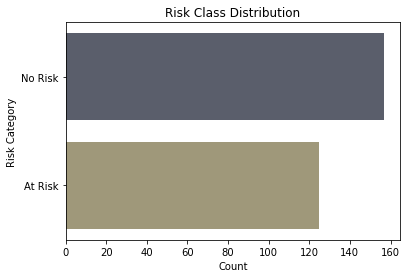

<Figure size 432x288 with 0 Axes>

In [6]:
sns.barplot(data=heartgraph,x='age_bucket',y='risk_category',palette='cividis')
plt.ylabel('Risk Category')
plt.xlabel('Count')
plt.title('Risk Class Distribution')

plt.figure()

### Null Information Rate
    
The class distribution can be used to obtain the null accuracy rate. The null accuracy rate will be used for comparison of future models. The null accuracy rate is the accuracy rate that could be achieved if the largest class label was applied to all rows of the dataset. If all rows were labeled as no risk of heart disease, an accuracy rate of 55% could be achieved. A machine learning model needs to beat this rate to be of any use.

<b>Null info accuracy rate of 157/282 = 55%<b>
    
## Visualizing the Data with Principal Component Analysis

Principal Component Analysis (PCA) reduces highly dimensional data down into 2 or 3 dimensions. The variables that result from PCA represent the total variation of the dataset in a lower dimensional space. These 2-dimensional representations can be plotted on a scatterplot and colored with the target labels to present a visual representation of the variation in the dataset. This is shown in the graph below. <BR>


Text(0.5, 1.0, 'Projection of clustering using PCA')

<Figure size 432x288 with 0 Axes>

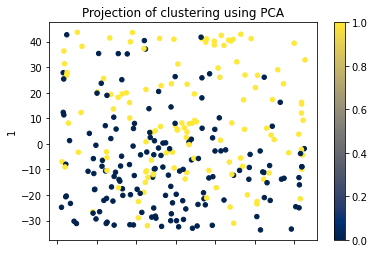

In [7]:
#create PCA object
pca = PCA()
#reduce dimensonality of the features
data_reduced = pca.fit_transform(features)
data_reduced = pd.DataFrame(data_reduced)
#plot chart of PCA results with kmean labels
plt.figure()
ax2 = data_reduced.plot(kind='scatter', x=0, y=1,c=targets, cmap='cividis')
plt.title('Projection of clustering using PCA')

### PCA Discussion
    
The PCA reduced dataset shows a gradient of color spreading from dark blue in the lower left-hand corner to yellow in the upper right. <br>
    
The results of PCA show that the classes are comingled. It may be difficult to create a decision boundary that can be used for prediction with jumbled classes. Additional data preparation may be needed to separate classes in the dataset.

## Feature Correlation

The final type of EDA that will be performed is a visualization of feature correlation using a correlation heatmap. This heatmap shows the strength of correlation to the target variable for each feature in the dataset.

<AxesSubplot:>

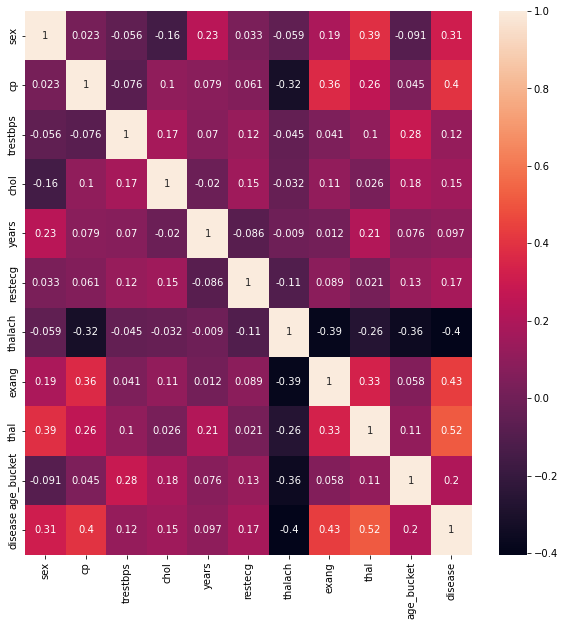

In [8]:
#plot a correlation heatmap
f = plt.figure(figsize=(10, 10))
sns.heatmap(heart_df.corr(), annot=True)

### Correlation Discussion

The correlation heatmap shows some very strong relationships between the target variable and other features in the dataset. Sex, cb, trestbps, chol, restecg, thalach, exand, thal, and age_bucket (created to discretize age last week) all have significant correlation to the target variable. There is very little correlation to the feature years, representing the length of time a person has smoked. The years variable may be a candidate for transformation (discretization) or removal from the dataset.


# Objective: K= 1 Nearest Neighbors Model

The K Nearest Neighbors algorithm works by making a prediction for a variable based on its proximity to neighboring datapoints. The value given for K is the number of neighboring datapoints to include in the prediction. To start, a model will be made that uses a K value of 1 to predict for the presence of heart disease in the dataset.


In [9]:
#create model for KNN
k_one_model = KNeighborsClassifier(n_neighbors=1)

#fit model on training data
k_one_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [10]:
#score classifier on training
k_one_model.score(X_train, y_train)

1.0

In [11]:
# score classifier on test
k_one_model.score(X_test, y_test)

0.631578947368421


## K=1 Model Discussion

### Accuracy Discussion


The K=1 model achieved an accuracy score of 100% on training and 63% on test. The high accuracy on training data and comparatively low accuracy on test suggest the K=1 model is overfit to its training data. It was able to outperform the null information rate. The null information rate was 55%, which was outperformed by the K=1 model by 8%. <br>


Accuracy on training data = 100%<br>
Accuracy on test data = 63%%<br>
<b>The k=1 model outperformed performed the null information rate by 8%.</b><br>

With classification models, raw accuracy alone does not illustrate how the model performs. Additional insight into how the model predicts can be gained by plotting a confusion matrix.

### The Confusion Matrix

A confusion matrix shows how a classification model predicted against the ground truth labels of the dataset. A model that predicts accurately should have a dark diagonal bar across the center of the confusion matrix representing predictions that were the same as the ground truth labels. A confusion matrix is plotted for the k=1 model with the code below.


Confusion matrix, without normalization
[[23 14]
 [ 7 13]]


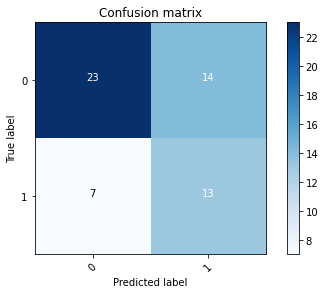

In [12]:
#Create a Confusion Matrix
#Generate predictions
X_test_pred = k_one_model.predict(X_test)

#define confusion matrix object, set true labels and preds 
cm = confusion_matrix(y_test, X_test_pred)

#plot confusion matrix
plt.figure()
class_names = ['0','1']
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix')

plt.show()

### Confusion Matrix Discussion
The confusion matrix reveals that the model had a difficult time discerning which patients did not have heart disease in the dataset. It predicted class 0 "no risk" 30 times, and class 1 "risk" 27 times. The majority of its accuracy came from predictions for class 0 on a test set that contained many examples of class 0. The randomly selected test split chosen for the model may be biasing its accuracy metrics.

### Visualizing the Results with PCA

The prediction results can be plotted with PCA. PCA can visualize the grouping of prediction results in the same way the ground truth labels were represented in the scatterplot above. The PCA plot for k=1 prediction targets illustrate the difficulty the k=1 model had creating a decision boundary. The target labels are all mixed in the scatterplot below.


Text(0.5, 1.0, 'Projection of clustering using PCA')

<Figure size 432x288 with 0 Axes>

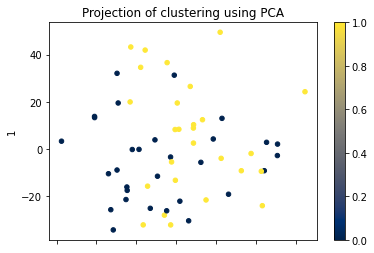

In [13]:
#reduce dimensonality of the features
data_reduced = pca.fit_transform(X_test)
data_reduced = pd.DataFrame(data_reduced)
#plot chart of PCA results with kmean labels
plt.figure()
ax2 = data_reduced.plot(kind='scatter', x=0, y=1,c=X_test_pred, cmap='cividis')
plt.title('Projection of clustering using PCA')

# Objective: K=Optimum Nearest Neighbors

The K value of 1 selected as a hyperparameter for the first model contributed to its overfitting on training data as well as its poor accuracy on test. For any dataset and model there will be an optimal combination of hyperparameters that can be found to improve its performance. To find the optimum K number, a brute force search will be conducted to check K values between 1 and 21. The test accuracy results from different neighbor numbers will be plotted on a line graph to assist in finding an optimal K value for the model. This operation is performed in the cell below.


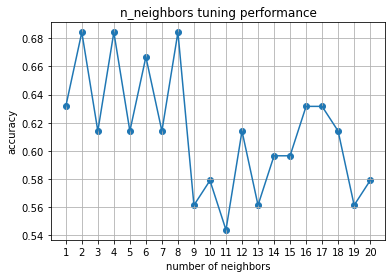

In [14]:
#test a single hyperparameter
#define scores
scores = []
lowend=1
highend=21

# select range for extensive search
for k in range(lowend, highend):
    
    # define and fit model
    model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
    
# display the results
plt.plot(range(lowend, highend), scores)
plt.scatter(range(lowend, highend), scores)
plt.title('n_neighbors tuning performance')
plt.ylabel('accuracy')
plt.xlabel('number of neighbors')
plt.grid()
_ =plt.xticks(range(lowend, highend))

## Optimum Neighbor Number K=4

As shown in the line graph, the optimum K numbers for this model are either 2, 4, or 8. A model will be trained using a k value of 4 in the code below.


In [15]:
#create model for KNN
k_four_model = KNeighborsClassifier(n_neighbors=4)

#fit model on training data
k_four_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [16]:
#score classifier on training
k_four_model.score(X_train, y_train)

0.7111111111111111

In [17]:
# score classifier on test
k_four_model.score(X_test, y_test)

0.6842105263157895

## K=4 Model Discussion

### Accuracy Discussion


The k=4 model improved on the score of the k=1 model, achieving an accuracy score of 71% on training and 68% on test. These close training and test scores indicate the model will generalize well when exposed to new data. It was able to exceed the accuracy of the null information rate of 55% by 13%


Accuracy on training data = 71%<br>
Accuracy on test data = 68%<br>
<b>The k=4 model outperformed k=1 by 5%<br></b>
The k=4 model outperformed the null information rate by 13%<br>

### K=4 Confusion Matrix



Confusion matrix, without normalization
[[28  9]
 [ 9 11]]


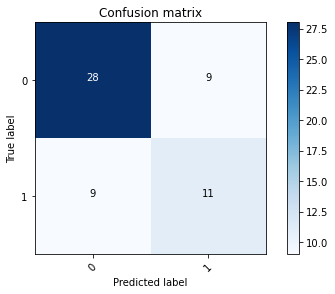

In [18]:
# Generate predictions
X_test_pred = k_four_model.predict(X_test)

#define confusion matrix object, set true labels and preds 
cm = confusion_matrix(y_test, X_test_pred)

#plot confusion matrix
plt.figure()
class_names = ['0','1']
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix')

plt.show()

### Confusion Matrix and PCA Discussion

Once again, the confusion matrix reveals that the accuracy of the model primarily comes from predictions of 0 on a randomly chosen test set that contains many examples of rows labeled with 0.<br>

The predictions made by the k=4 model can be visualized using PCA. The predicted labels are starting to display the trend identified in the original PCA scatterplot which showed a gradient of dark to light from lower left to upper right.


Text(0.5, 1.0, 'Projection of clustering using PCA')

<Figure size 432x288 with 0 Axes>

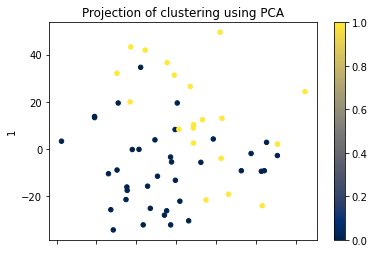

In [19]:
#reduce dimensonality of the features
data_reduced = pca.fit_transform(X_test)
data_reduced = pd.DataFrame(data_reduced)
#plot chart of PCA results with kmean labels
plt.figure()
ax2 = data_reduced.plot(kind='scatter', x=0, y=1,c=X_test_pred, cmap='cividis')
plt.title('Projection of clustering using PCA')

# Objective: Improve Your Model

## Feature Scaling/Normalization
Machine learning algorithms prefer numbers to be scaled or normalized for comparison. One place this comes into effect is when features in the dataset are recorded in different units, like heart rate and number of years smoked in the heart disease dataset. These different unit types cannot be accurately compared without conversion to a common scale. The other place this can affect a model is with a feature that has a huge range of values. A feature containing huge numbers in comparison to the rest of the features can be overweighted by the model. The way to overcome this obstacle is to scale the features in the dataset. <br>

The process of scaling/normalization has been conducted on the features in the heart risk dataset using scikit learn's minmaxscaler. The minmax scaling process assigns a float value between 0 and 1 to each row corresponding to its value when compared to all other values in that feature.  <br>

Scaling is not applied to the prediction variable "disease" to maintain the ability to predict for labels in the dataset.



In [20]:
#create new df to hold scaled features
scaled_heart_df = heart_df

In [21]:
#define scaler objext
scaler = MinMaxScaler()

In [22]:
#scale features:
scaled_heart_df['age_bucket'] = scaler.fit_transform(scaled_heart_df['age_bucket'].values.reshape(-1,1))
scaled_heart_df['sex'] = scaler.fit_transform(scaled_heart_df['sex'].values.reshape(-1,1))
scaled_heart_df['cp'] = scaler.fit_transform(scaled_heart_df['cp'].values.reshape(-1,1))
scaled_heart_df['trestbps'] = scaler.fit_transform(scaled_heart_df['trestbps'].values.reshape(-1,1))
scaled_heart_df['chol'] = scaler.fit_transform(scaled_heart_df['chol'].values.reshape(-1,1))
scaled_heart_df['years'] = scaler.fit_transform(scaled_heart_df['years'].values.reshape(-1,1))
scaled_heart_df['restecg'] = scaler.fit_transform(scaled_heart_df['restecg'].values.reshape(-1,1))
scaled_heart_df['thalach'] = scaler.fit_transform(scaled_heart_df['thalach'].values.reshape(-1,1))
scaled_heart_df['exang'] = scaler.fit_transform(scaled_heart_df['exang'].values.reshape(-1,1))
scaled_heart_df['thal'] = scaler.fit_transform(scaled_heart_df['thal'].values.reshape(-1,1))

In [23]:
#divide into train and test split
scaled_features = scaled_heart_df.drop('disease', axis=1)
scaled_targets = scaled_heart_df['disease']

##break data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_targets, test_size=0.2,random_state=1)

# Visualizing the Scaling Effect with PCA

Scaling these features has significantly changed the PCA scatterplot of the data. There are now distinct clusters that have formed. A few of these clusters show a preference for the presence or absence of heart disease.


Text(0.5, 1.0, 'Projection of clustering using PCA')

<Figure size 432x288 with 0 Axes>

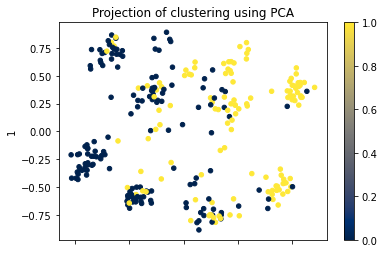

In [24]:
#reduce dimensonality of the features
data_reduced = pca.fit_transform(scaled_features)
data_reduced = pd.DataFrame(data_reduced)
#plot chart of PCA results with kmean labels
plt.figure()
ax2 = data_reduced.plot(kind='scatter', x=0, y=1,c=scaled_targets, cmap='cividis')
plt.title('Projection of clustering using PCA')

## Optimum Scaled Neighbor Number K=16

As shown in the line graph below, the optimum K number for the scaled test is 16. A model will be trained using a k value of 16 in the code below.


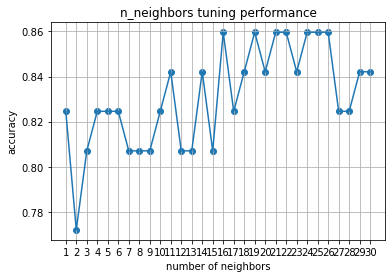

In [25]:
#test a single hyperparameter
#define scores
scores = []
lowend=1
highend=31

# select range for extensive search
for k in range(lowend, highend):
    
    # define and fit model
    model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
    
# display the results
plt.plot(range(lowend, highend), scores)
plt.scatter(range(lowend, highend), scores)
plt.title('n_neighbors tuning performance')
plt.ylabel('accuracy')
plt.xlabel('number of neighbors')
plt.grid()
_ =plt.xticks(range(lowend, highend))

In [26]:
#create model for KNN
scaled_k_model = KNeighborsClassifier(n_neighbors=16)

#fit model on training data
scaled_k_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=16)

In [27]:
#score classifier on training
scaled_k_model.score(X_train, y_train)

0.8088888888888889

In [28]:
# score classifier on test
scaled_k_model.score(X_test, y_test)

0.8596491228070176

## Scaled K Model Discussion

### Accuracy Discussion


The scaled k model improved on the score of the k=4 model, achieving an accuracy score of 80% on training and 85% on test. It was able to exceed the accuracy of the null information rate of 55% by 30%. The scaled k model has the best performance of any model created so far.


Accuracy on training data = 80%<br>
Accuracy on test data = 85%<br>
The scaled k model outperformed k=1 by 22%<br>
<b>The scaled k model outperformed k=4 by 17%<br></b>
The scaled k model outperformed the null information rate by 30%<br>

### Scaled Confusion Matrix


Confusion matrix, without normalization
[[36  1]
 [ 7 13]]


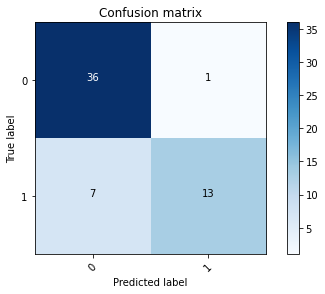

In [29]:
#Generate predictions
scaled_X_test_pred = scaled_k_model.predict(X_test)

#define confusion matrix object, set true labels and preds 
cm = confusion_matrix(y_test, scaled_X_test_pred)
#plot confusion matrix
plt.figure()
class_names = ['0','1']
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix')

plt.show()

### Confusion Matrix and PCA Discussion

The confusion matrix demonstrates the improved accuracy achieved by feature scaling. However, much of the accuracy of the model comes from prediction of the majority class in a randomly chosen test sample that contains many examples of that class. The accuracy bias in the test set is affecting the selection of hyperparameters and needs to be addressed in the models construction. This can be done by using cross validation scoring which will be performed in the next set of code.

The predictions made by the scaled k model can be visualized using PCA. This scatterplot follows the pattern in the first PCA scatterplot of scaled data which showed distinct clusters forming in the dataset. There is a clear prediction boundary that has been formed separating data on the right and left sides of the plot. The clustering that resulted from scaling is responsible for the increased accuracy of the model in this test.



Text(0.5, 1.0, 'Projection of clustering using PCA')

<Figure size 432x288 with 0 Axes>

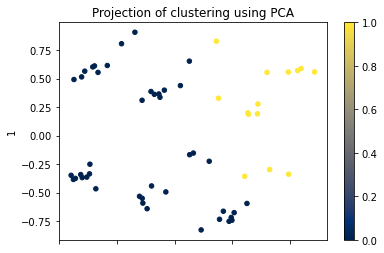

In [30]:
#reduce dimensonality of the features
data_reduced = pca.fit_transform(X_test)
data_reduced = pd.DataFrame(data_reduced)
#plot chart of PCA results with kmean labels
plt.figure()
ax2 = data_reduced.plot(kind='scatter', x=0, y=1,c=scaled_X_test_pred, cmap='cividis')
plt.title('Projection of clustering using PCA')

# Testing Model Accuracy with Cross Validation.

Cross validation can be used to test the accuracy of the KNN model multiple times against a random assortment of training and test sets. The scores of these tests are averaged together to generate a performance metric for the model. Cross validation testing on a KNN model removes the bias that exists from randomly selecting a sample that contains many examples of an easy to predict for class. When the normalized data is tested with cross validation, the best accuracy that can be achieved by the model is slightly above 68% where K=22. This performance is significantly worse than the accuracy shown when testing the scaled k model on the original test set, but is a better representation of the models overall performance on the dataset.

### Benefits of Model Hyperparameters Chosen with Cross Validation

A KNN model that has been tuned with cross validation has seen a wider variety of training and test splits. The hyperparameters recommended by this model should generalize better to unseen data. The results of the cross validated KNN test on normalized data is shown below.

### Choosing an Optimum K Value with Cross Validation Scoring
 
The results of the cross validation test suggest a K value of 22 for optimal prediction by the model.


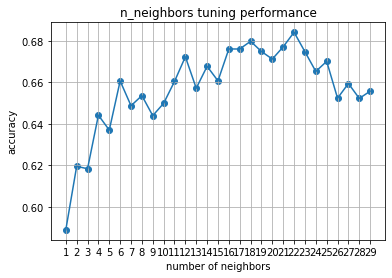

In [31]:
#test a single hyperparameter
#define scores
scores = []
lowend=1
highend=30

# select range for extensive search
for k in range(lowend, highend):
    
    # define and fit model
    model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scored = cross_val_score(model, features, targets, scoring='accuracy', cv=cv, n_jobs=-1)
    scores.append(mean(scored))
    
# display the results
plt.plot(range(lowend, highend), scores)
plt.scatter(range(lowend, highend), scores)
plt.title('n_neighbors tuning performance')
plt.ylabel('accuracy')
plt.xlabel('number of neighbors')
plt.grid()
_ =plt.xticks(range(lowend, highend))

In [32]:
#create model for KNN
cv_k_model = KNeighborsClassifier(n_neighbors=22)

#fit model on training data
cv_k_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=22)

In [33]:
#score classifier on training
cv_k_model.score(X_train, y_train)

0.8222222222222222

In [34]:
# score classifier on test
cv_k_model.score(X_test, y_test)

0.8596491228070176

# Cross Validation Model Discussion

<b> Accuracy</b><br>
The cross-validation model was able to outperform the null information rate by 30%, achieving a prediction accuracy of 85% on the dataset compared to a null information rate of 55%. It performed similarly to the scaled_k_model, but had a higher accuracy on training data, achieving 82% when tested on training compared to 80% in the scaled model. The increased accuracy on training data suggests the model selected with hyperparameters from cross validation is better generalized than the scaled model and should perform better when presented with never-before-seen data. <br>

<b>Accuracy on training data = 82%, a 2% improvement over the scaled k model</b><br>
Accuracy on test data = 85%<br>
The scaled k model outperformed k=1 by 22%<br>
The scaled k model outperformed k=4 by 17%<br>
The cv model had the same accuracy as the scaled k model
The cv k model outperformed the null information rate by 30%<br>


Confusion matrix, without normalization
[[35  2]
 [ 6 14]]


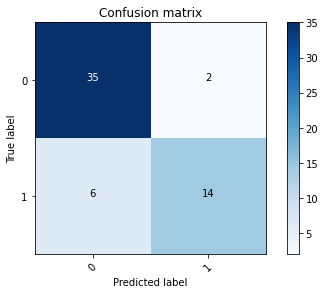

In [35]:
#Generate predictions
cv_X_test_pred = cv_k_model.predict(X_test)

#define confusion matrix object, set true labels and preds 
cm = confusion_matrix(y_test, cv_X_test_pred)

#plot confusion matrix
plt.figure()
class_names = ['0','1']
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix')

plt.show()



<b> Confusion Matrix</b><br>
The cv confusion matrix shows about the same level of accuracy and predictions between the classes as was demonstrated by the scaled K model. The model only mislabeled 8 out of 57 samples from the test dataset. <br>

<b>PCA</b><br>
The PCA scatterplot of the CV model continues to show a smooth decision boundary that separates the risk of heart disease on the left and right of the scatterplot.

Text(0.5, 1.0, 'Projection of clustering using PCA')

<Figure size 432x288 with 0 Axes>

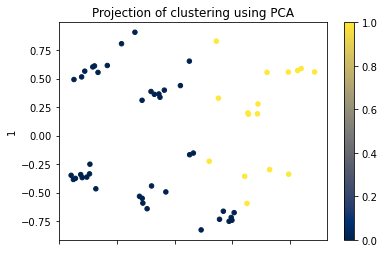

In [36]:
#reduce dimensonality of the features
data_reduced = pca.fit_transform(X_test)
data_reduced = pd.DataFrame(data_reduced)
#plot chart of PCA results with kmean labels
plt.figure()
ax2 = data_reduced.plot(kind='scatter', x=0, y=1,c=cv_X_test_pred, cmap='cividis')
plt.title('Projection of clustering using PCA')




# Conclusion

The original train_test_split that was randomly selected contained many examples of an easy to predict for class in the test set. This imbalanced split lead to misleading accuracy scores that were revealed through investigation of the results with a confusion matrix and comparison of decision boundaries with PCA. This discovery led to the implementation of cross validation scoring to prove the bias of the original train_test_split. After proving bias in the test split, a model was constructed using hyperparameters selected by CV which had closer training and test scores, suggesting it is better generalized to the prediction task.



# References

This notebook was created using a blend of techniques from Regis's MSDS600, MSDS680, and MSDS650 coursework. In addition to this, the reference literature for sci-kit learn, pandas, and seaborn was consulted to construct the code.

Janosi, A,. Steinbrunn, W., Pfisterer, M., & Detrano, R. (1988). <i>Heart Disease Data Set</i>. UCI Machine Learning Repository. Retrieved 08/02/2022 from http://archive.ics.uci.edu/ml/datasets/heart+Disease

Pandas Development Team. 2021. <i>Python API reference</i> from pandas.pydata.org https://pandas.pydata.org/docs/reference/index.html

Pedregosa et al. (2011). Scikit-learn: Machine Learning in Python. <i> Journal of Machine Learning Research 12,</i> 2825-2830

Waskom ML (2021). seaborn: statistical data visualization. <i> Journal of Open Source Software 6</i>(60): 3021.a